In [1]:
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
data_dir = pathlib.Path("chest_xray")

NameError: name 'pathlib' is not defined

In [4]:
image_count = len(list(data_dir.glob('**/*.jpg')))
print(image_count)

NameError: name 'data_dir' is not defined

In [5]:
!ls chest_xray/train/NORMAL | grep .jpeg | wc -l

1341


In [6]:
!ls chest_xray/train/PNEUMONIA | grep .jpeg | wc -l

3875


In [7]:
!ls chest_xray/test/NORMAL | grep .jpeg | wc -l

234


In [8]:
!ls chest_xray/test/PNEUMONIA | grep .jpeg | wc -l

390


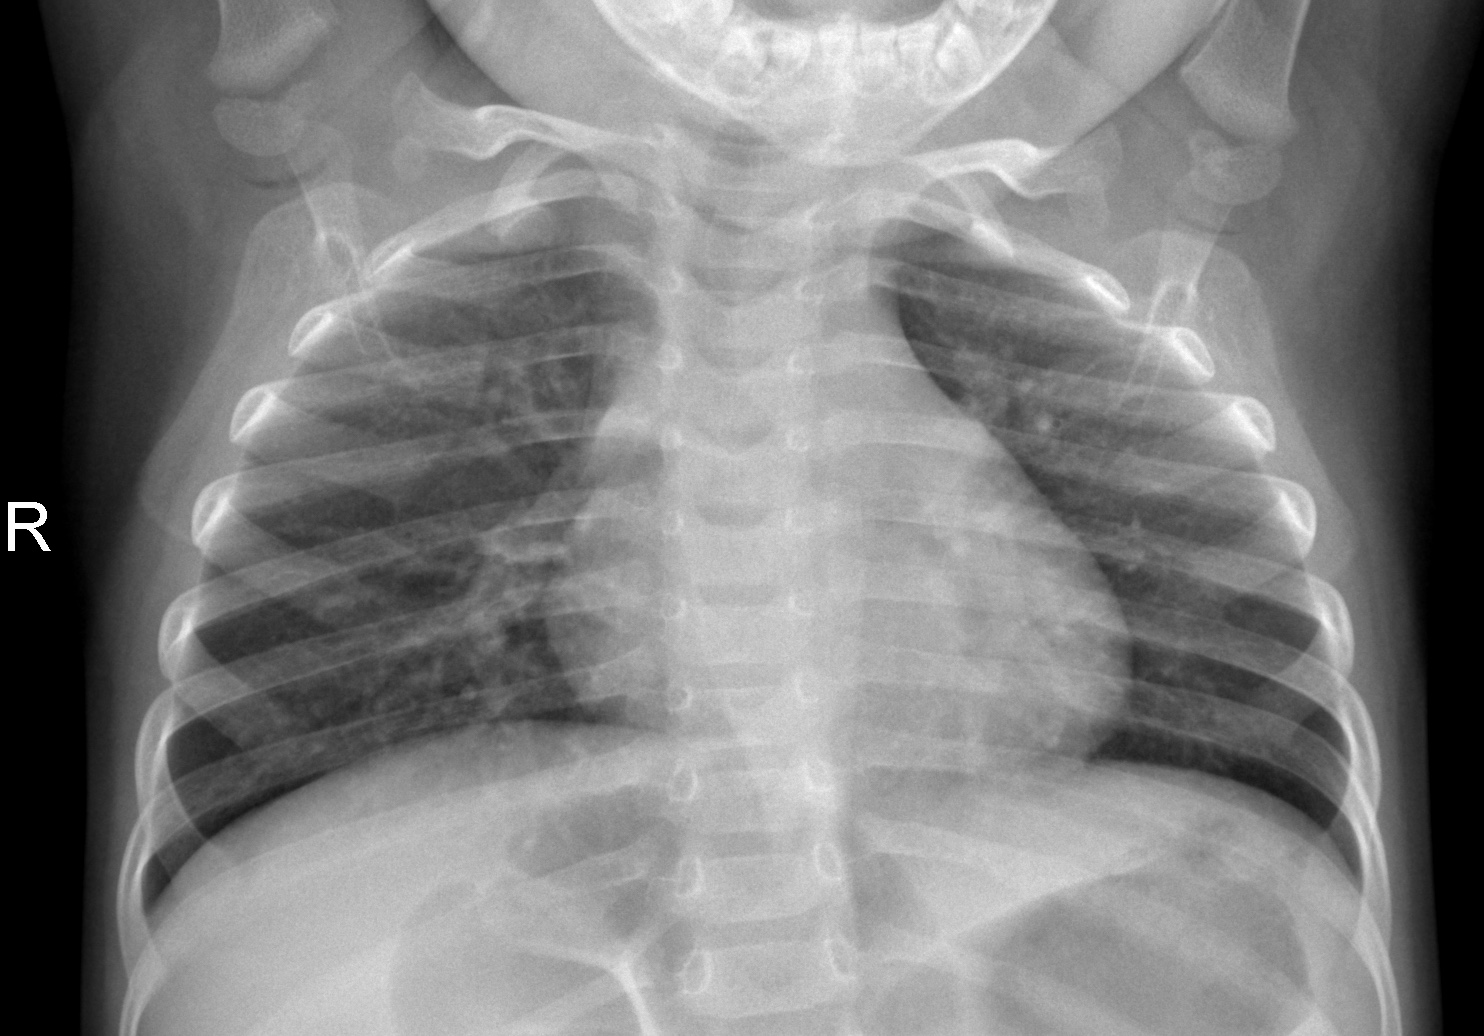

In [9]:
normal = list(data_dir.glob('**/train/NORMAL/*.jpeg'))
PIL.Image.open(str(normal[0]))

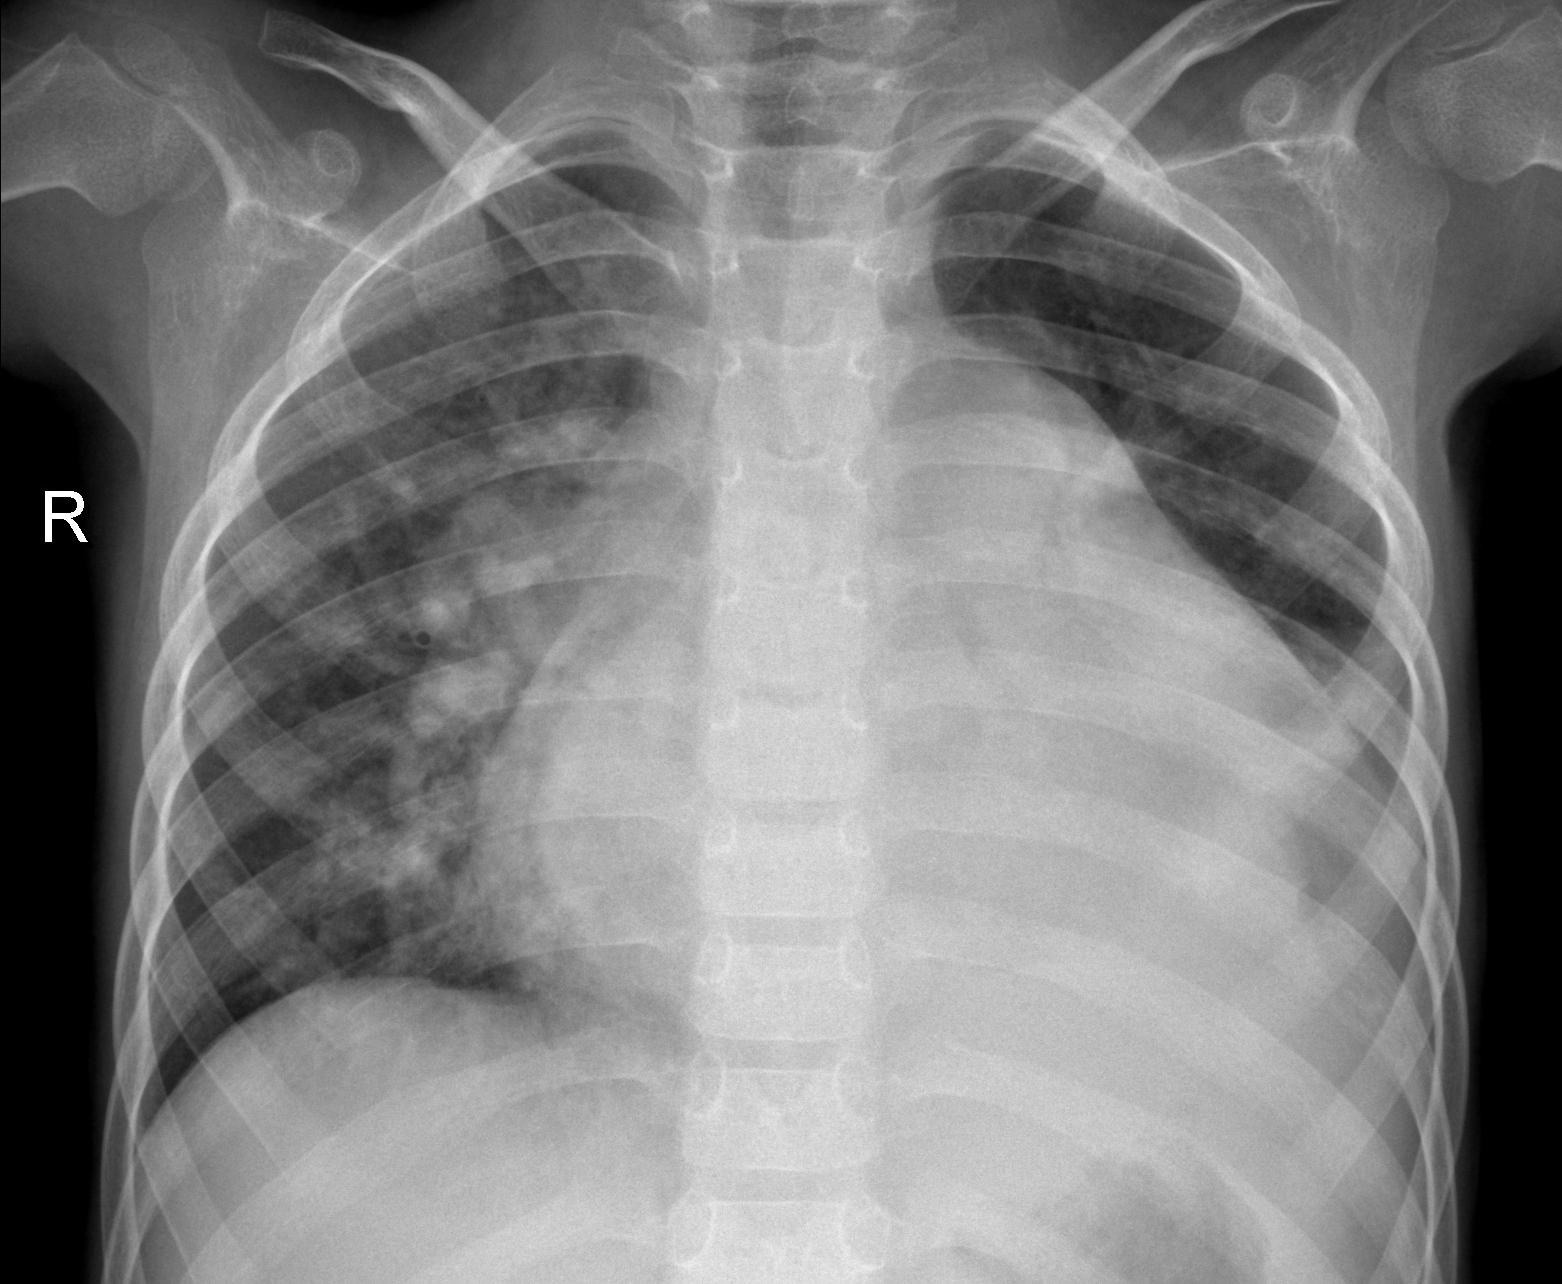

In [10]:
normal = list(data_dir.glob('**/train/PNEUMONIA/*.jpeg'))
PIL.Image.open(str(normal[5]))

In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
train_dir = pathlib.Path("chest_xray/train")
test_dir =  pathlib.Path("chest_xray/test")

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=362,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5218 files belonging to 2 classes.


In [14]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=362,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 624 files belonging to 2 classes.


In [15]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


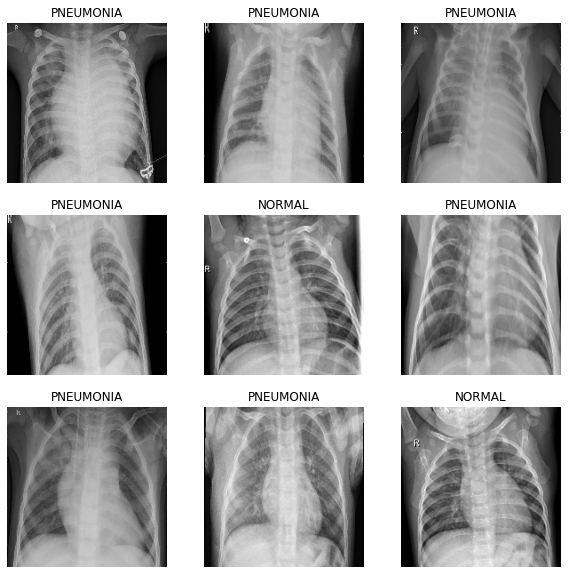

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [20]:
model.compile(
  optimizer='adam',
  loss=tf.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [21]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
164/164 [==============================] - 25s 132ms/step - loss: 0.4626 - accuracy: 0.8012 - val_loss: 0.9968 - val_accuracy: 0.7324
Epoch 2/10
164/164 [==============================] - 6s 39ms/step - loss: 0.1152 - accuracy: 0.9564 - val_loss: 0.9935 - val_accuracy: 0.7548
Epoch 3/10
164/164 [==============================] - 6s 39ms/step - loss: 0.0850 - accuracy: 0.9720 - val_loss: 1.0110 - val_accuracy: 0.7532
Epoch 4/10
164/164 [==============================] - 6s 39ms/step - loss: 0.0700 - accuracy: 0.9734 - val_loss: 1.4285 - val_accuracy: 0.7003
Epoch 5/10
164/164 [==============================] - 6s 39ms/step - loss: 0.0667 - accuracy: 0.9787 - val_loss: 0.9771 - val_accuracy: 0.7692
Epoch 6/10
164/164 [==============================] - 6s 39ms/step - loss: 0.0582 - accuracy: 0.9780 - val_loss: 1.1177 - val_accuracy: 0.7756
Epoch 7/10
164/164 [==============================] - 6s 39ms/step - loss: 0.0441 - accuracy: 0.9820 - val_loss: 2.0079 - val_accuracy: 0.72

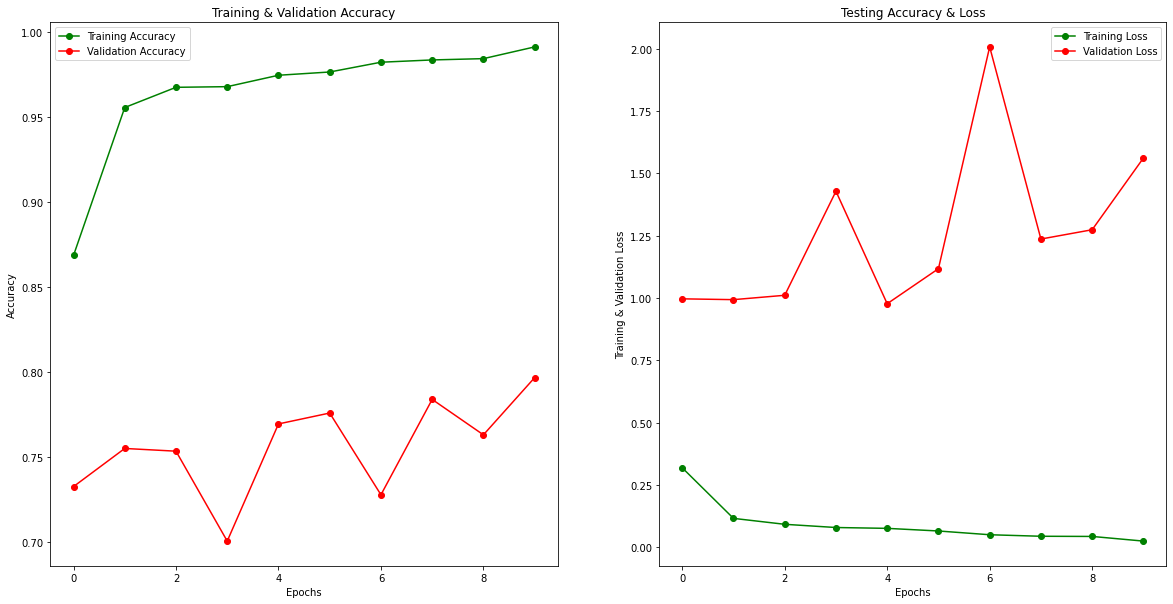

In [22]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0

### overfit model, try adding dropout and more convs (to fix acc on val set)

In [24]:
model_dropout = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [25]:
model_dropout.compile(
  optimizer='adam',
  loss=tf.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [26]:
history2 = model_dropout.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
164/164 [==============================] - 8s 44ms/step - loss: 0.4131 - accuracy: 0.8167 - val_loss: 0.7559 - val_accuracy: 0.7244
Epoch 2/10
164/164 [==============================] - 7s 43ms/step - loss: 0.1525 - accuracy: 0.9401 - val_loss: 0.6625 - val_accuracy: 0.7837
Epoch 3/10
164/164 [==============================] - 7s 42ms/step - loss: 0.1293 - accuracy: 0.9535 - val_loss: 0.6556 - val_accuracy: 0.7949
Epoch 4/10
164/164 [==============================] - 7s 43ms/step - loss: 0.1096 - accuracy: 0.9596 - val_loss: 0.6970 - val_accuracy: 0.7949
Epoch 5/10
164/164 [==============================] - 7s 43ms/step - loss: 0.0807 - accuracy: 0.9693 - val_loss: 0.6510 - val_accuracy: 0.8077
Epoch 6/10
164/164 [==============================] - 7s 42ms/step - loss: 0.0755 - accuracy: 0.9725 - val_loss: 0.9201 - val_accuracy: 0.7740
Epoch 7/10
164/164 [==============================] - 7s 42ms/step - loss: 0.0692 - accuracy: 0.9723 - val_loss: 0.7921 - val_accuracy: 0.7804

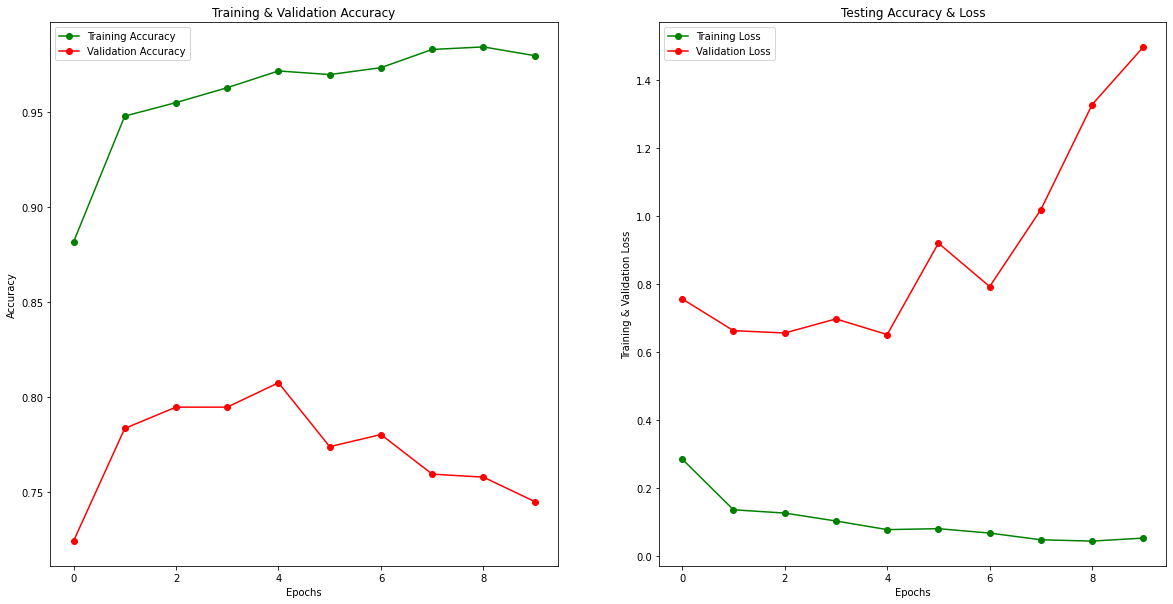

In [27]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history2.history['accuracy']
train_loss = history2.history['loss']
val_acc = history2.history['val_accuracy']
val_loss = history2.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [37]:
model_dropout2 = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(256, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [38]:
model_dropout2.compile(
  optimizer='adam',
  loss=tf.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [30]:
history2 = model_dropout2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
164/164 [==============================] - 22s 126ms/step - loss: 0.2873 - accuracy: 0.8957 - val_loss: 4.0110 - val_accuracy: 0.6250
Epoch 2/10
164/164 [==============================] - 19s 118ms/step - loss: 0.0957 - accuracy: 0.9647 - val_loss: 5.9805 - val_accuracy: 0.6250
Epoch 3/10
164/164 [==============================] - 19s 116ms/step - loss: 0.0855 - accuracy: 0.9695 - val_loss: 1.5728 - val_accuracy: 0.6811
Epoch 4/10
164/164 [==============================] - 19s 115ms/step - loss: 0.0723 - accuracy: 0.9730 - val_loss: 0.8033 - val_accuracy: 0.7756
Epoch 5/10
164/164 [==============================] - 19s 115ms/step - loss: 0.0505 - accuracy: 0.9792 - val_loss: 0.5198 - val_accuracy: 0.8478
Epoch 6/10
164/164 [==============================] - 19s 116ms/step - loss: 0.0456 - accuracy: 0.9841 - val_loss: 1.5760 - val_accuracy: 0.7067
Epoch 7/10
164/164 [==============================] - 18s 112ms/step - loss: 0.0425 - accuracy: 0.9843 - val_loss: 0.6581 - val_ac

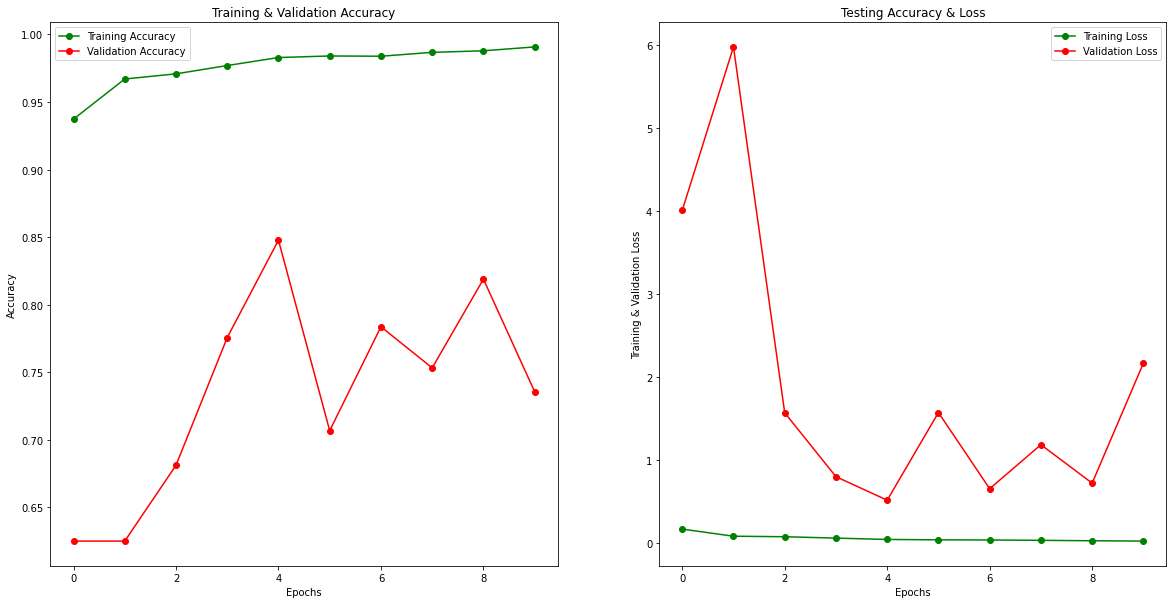

In [31]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history2.history['accuracy']
train_loss = history2.history['loss']
val_acc = history2.history['val_accuracy']
val_loss = history2.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

### use data augmentation

In [23]:
from tensorflow.keras import layers

model_dropout2 = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.RandomZoom(.2),
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomRotation(factor=30),
    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

In [25]:
model_dropout2.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
  loss=tf.losses.BinaryCrossentropy(from_logits=False),
  metrics=['binary_accuracy'])

In [26]:
history2 = model_dropout2.fit(
  train_ds,
  validation_data=val_ds,
  callbacks = [early_stopping],
  epochs=100
)

Epoch 1/100
164/164 [==============================] - 12s 63ms/step - loss: 0.5921 - binary_accuracy: 0.7789 - val_loss: 1.5512 - val_binary_accuracy: 0.6250
Epoch 2/100
164/164 [==============================] - 10s 59ms/step - loss: 0.2427 - binary_accuracy: 0.9002 - val_loss: 2.3577 - val_binary_accuracy: 0.6250
Epoch 3/100
164/164 [==============================] - 10s 59ms/step - loss: 0.1931 - binary_accuracy: 0.9220 - val_loss: 1.5680 - val_binary_accuracy: 0.6619
Epoch 4/100
164/164 [==============================] - 10s 59ms/step - loss: 0.1797 - binary_accuracy: 0.9312 - val_loss: 0.5045 - val_binary_accuracy: 0.8590
Epoch 5/100
164/164 [==============================] - 10s 59ms/step - loss: 0.1772 - binary_accuracy: 0.9324 - val_loss: 0.3091 - val_binary_accuracy: 0.8686
Epoch 6/100
164/164 [==============================] - 10s 59ms/step - loss: 0.1603 - binary_accuracy: 0.9403 - val_loss: 0.4086 - val_binary_accuracy: 0.8349
Epoch 7/100
164/164 [=========================

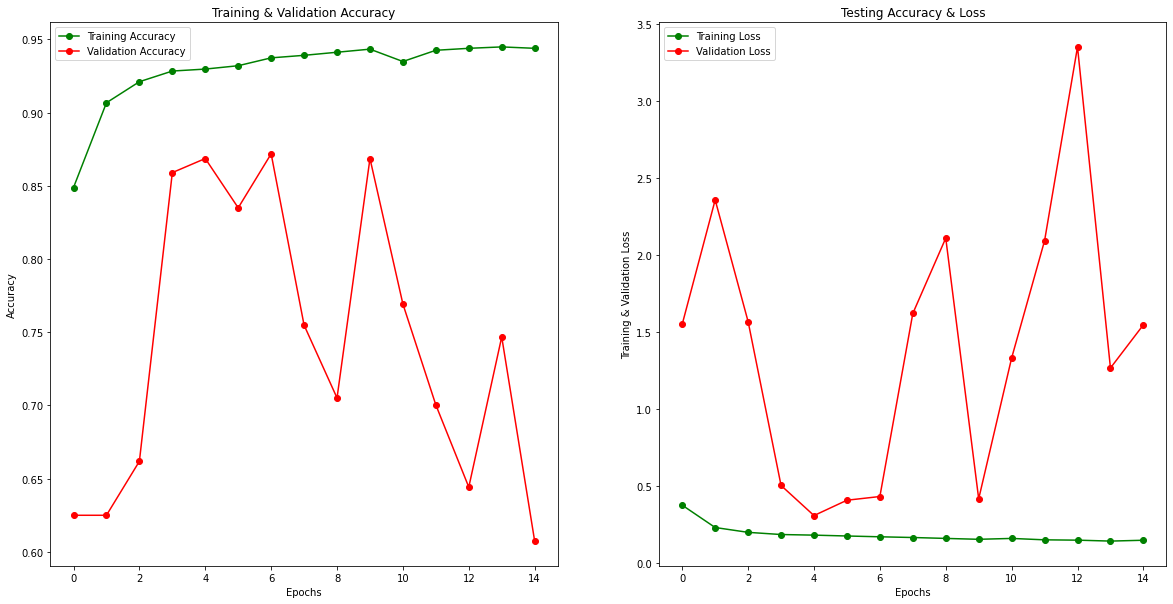

In [28]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history2.history['binary_accuracy']
train_loss = history2.history['loss']
val_acc = history2.history['val_binary_accuracy']
val_loss = history2.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()